Data Analysis Plan
---
Goal: Test multiple models on the relationship between IGT scores & ventral striatal sensitivity between DRD2 carrier groups

- Grab variables of interest
    - P = D.P_payoff
    - Q = D.Q_sensitivity 
    - VS = D.Cards_RNR_VS_mean 
    - AGE = D.AGE
    - SEX = D.female_1
    <br><br>
- Filter to only get subjects who have data for P and VS, and who are white <br><br>
    good=find(~isnan(VS) & ~isnan(P) & D.white(1)<br>
    good_subs = zeros(size(AGE))<br>
    good_subs(good) = 1<br>
    N = length(D.AGE(good))<br>
    <br>
- Separate by DRD2 polymorphism<br><br>
    1 = Del. carrier (low D2) <br>
    0 = Ins/Ins (normal D2) <br>
    drd2_high = find(good_subs & D.DRD2_score==1) <br>
    drd2_low = find(good_subs & D.DRD2_score==0) <br>
    <br>
---

Analysis pipeline:

1. Demographic summary of groups:
    - Age
    - Sex
    - N (number in each group)
<br><br>
2. Group (DRD2 group) differences in:
    - VS
    - P
    - Q
    
         a.) visualize in graph <br>
         b.) analyze with t-test
<br><br>
3. Separate P vs. VS regressions for each group
    - Control for: Age & sex?


Dependencies

In [6]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats
from sklearn import linear_model

from statsmodels.compat import unicode
import statsmodels.api as sm

import plotly.plotly as py
#import plotly.express as px

pd.set_option('display.max_columns', 8)

ImportError: 
The plotly.plotly module is deprecated,
please install the chart-studio package and use the
chart_studio.plotly module instead. 


Demographic summary

In [8]:
data = pd.read_csv('DRD2_subset_data.csv', delimiter=',')
data = data.dropna(subset=['P','Q','VS','DRD2'])

# Age

AGE Summary: count    438.000000
mean      42.666667
std        7.370442
min       30.000000
25%       36.000000
50%       43.500000
75%       49.000000
max       54.000000
Name: AGE, dtype: float64


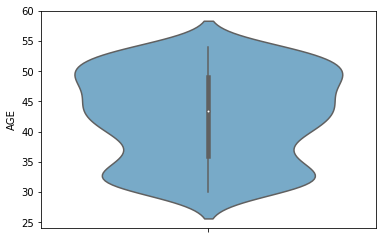

In [9]:
age_summary = data.AGE.describe()
print('AGE Summary:', age_summary)
AGE_violin = sb.violinplot(y='AGE', data=data, palette='Blues')


# Sex

Sex Summary: count    438.000000
mean       0.520548
std        0.500149
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: female_1, dtype: float64


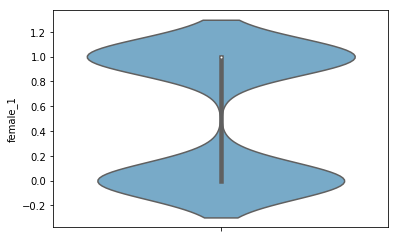

In [10]:
sex_summary = data.female_1.describe()
print('Sex Summary:', sex_summary)
SEX_violin = sb.violinplot(y='female_1', data=data, palette='Blues')

# IGT Scores

IGT Measures Summary 

 P 
 count    438.000000
mean      16.369863
std       29.908177
min      -92.000000
25%       -4.000000
50%       14.000000
75%       40.000000
max       96.000000
Name: P, dtype: float64 

 Q 
 count    438.000000
mean      31.616438
std       25.414800
min      -46.000000
25%       16.000000
50%       38.000000
75%       48.000000
max       86.000000
Name: Q, dtype: float64


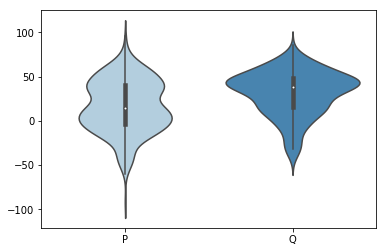

In [11]:
P_summary = data.P.describe()
Q_summary = data.Q.describe()
print('IGT Measures Summary','\n\n','P','\n', P_summary, '\n\n','Q','\n', Q_summary)
IGT_violin = sb.violinplot(data=data.iloc[:,2:4], palette='Blues')

# VS and Obesity

VS Summary 

 count    438.000000
mean       0.107567
std        0.166886
min       -0.543820
25%        0.008345
50%        0.099525
75%        0.204464
max        0.851100
Name: VS, dtype: float64
Obesity Summary 

 count    432.000000
mean      -0.004776
std        1.004456
min       -2.264433
25%       -0.785395
50%       -0.094756
75%        0.667557
max        2.721058
Name: Obesity, dtype: float64


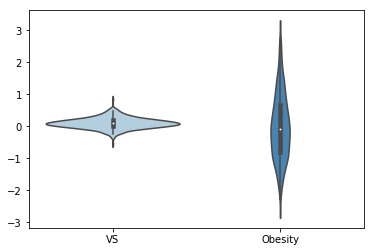

In [12]:
VS_summary = data.VS.describe()
Ob_summary = data.Obesity.describe()
print('VS Summary', '\n\n', VS_summary)
print('Obesity Summary', '\n\n', Ob_summary)
VS_Ob_violin = sb.violinplot(data=data.iloc[:,4:6], palette='Blues')

# DRD2

DRD2 Carrier Summary: count    438.000000
mean       0.271689
std        0.445339
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: DRD2, dtype: float64


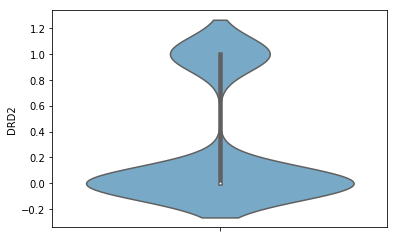

In [13]:
DRD2_summary = data.DRD2.describe()
print('DRD2 Carrier Summary:', DRD2_summary)
DRD2_violin = sb.violinplot(y='DRD2', data=data, palette='Blues')

If DRD2 == 1, subjects are DRD2 deletion carriers --> low D2 receptors --> High DA

If DRD2 == 0, subjects are DRD2 insertion carriers --> normal D2 receptors --> Low DA

In [14]:
high_DA = data[data['DRD2'] == 1]
low_DA = data[data['DRD2'] == 0]

# T-test
Standard Independent 2 sample test that assumes equal population variance

In [15]:
t_test_results = stats.ttest_ind(high_DA.iloc[:,2:5], low_DA.iloc[:,2:5], equal_var=True)
t_test_results

# P, Q, VS

Ttest_indResult(statistic=array([-3.23083657,  0.53904942, -1.77172964]), pvalue=array([ 0.00132777,  0.59012789,  0.07713785]))

Welch's Test which does not assume equal population variance

In [16]:
stats.ttest_ind(high_DA.iloc[:,2:5], low_DA.iloc[:,2:5], equal_var=False)

# P, Q, VS

Ttest_indResult(statistic=array([-3.2966212 ,  0.56431476, -1.7465982 ]), pvalue=array([ 0.00114068,  0.57308456,  0.08219884]))

# Histograms

### P Score between high and low DA groups

P Score T-test between high and low DA groups


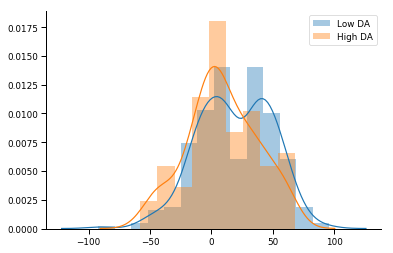

In [17]:
sb.set_context("paper")

high_DA_P_data = pd.concat([high_DA['P']], axis=1)
low_DA_P_data = pd.concat([low_DA['P']], axis=1)


print("P Score T-test between high and low DA groups")
scatter_P_low = sb.distplot(low_DA_P_data, label='Low DA')
scatter_P_high = sb.distplot(high_DA_P_data, label='High DA')
plt.legend();

sb.despine()

### Q Score T-test between high and low DA groups

Q Score T-test between high and low DA groups


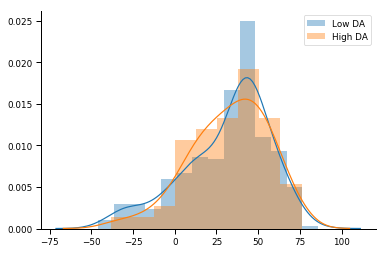

In [18]:
sb.set_context("paper")

high_DA_Q_data = pd.concat([high_DA['Q']], axis=1)
low_DA_Q_data = pd.concat([low_DA['Q']], axis=1)


print("Q Score T-test between high and low DA groups")
scatter_Q_low = sb.distplot(low_DA_Q_data, label='Low DA')
scatter_Q_high = sb.distplot(high_DA_Q_data, label='High DA')
plt.legend();


sb.despine()

### VS between high and low DA groups

VS T-test between high and low DA groups


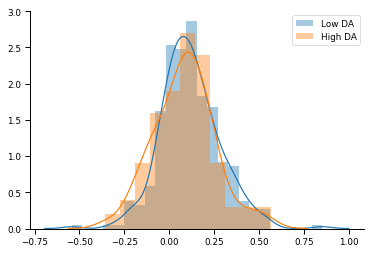

In [19]:
sb.set_context("paper")

high_DA_VS_data = pd.concat([high_DA['VS']], axis=1)
low_DA_VS_data = pd.concat([low_DA['VS']], axis=1)


print("VS T-test between high and low DA groups")
scatter_VS_low = sb.distplot(low_DA_VS_data, label='Low DA')
scatter_VS_high = sb.distplot(high_DA_VS_data, label='High DA')
plt.legend();


sb.despine()

# Linear Regressions

### High DA: P vs VS

In [36]:
target = pd.DataFrame(high_DA.P, columns=['P'])
x = pd.DataFrame(high_DA, columns=['VS'])
y = target['P']

lm = linear_model.LinearRegression()
model = lm.fit(x,y)

predictions = lm.predict(x)
#print(predictions)

print('score:', lm.score(x,y))
print('coefficients:', lm.coef_)
print('intercept:', lm.intercept_)


score: 0.00472846726021
coefficients: [ 11.56706436]
intercept: 7.91342611309


In [27]:
results = sm.OLS(x,y).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     VS   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.028
Method:                 Least Squares   F-statistic:                              4.491
Date:                Thu, 26 Sep 2019   Prob (F-statistic):                      0.0362
Time:                        15:36:58   Log-Likelihood:                          31.342
No. Observations:                 119   AIC:                                     -60.68
Df Residuals:                     118   BIC:                                     -57.90
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Low DA: P vs VS

In [42]:
target = pd.DataFrame(low_DA.P, columns=['P'])
x = pd.DataFrame(low_DA, columns=['VS'])
y = target['P']

lm = linear_model.LinearRegression()
model = lm.fit(x,y)

predictions = lm.predict(x)
#print(predictions)

print('score:', lm.score(x,y))
print('coefficients:', lm.coef_)
print('intercept:', lm.intercept_)


score: 0.0135859203897
coefficients: [ 21.14001795]
intercept: 16.7039254221


In [43]:
results = sm.OLS(x,y).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     VS   R-squared (uncentered):                   0.153
Model:                            OLS   Adj. R-squared (uncentered):              0.150
Method:                 Least Squares   F-statistic:                              57.45
Date:                Thu, 26 Sep 2019   Prob (F-statistic):                    3.83e-13
Time:                        15:54:53   Log-Likelihood:                          84.682
No. Observations:                 319   AIC:                                     -167.4
Df Residuals:                     318   BIC:                                     -163.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------